After exploration in 2021_CommonLitReadability notebook, the best model is re-implemented here for clarity.

In [1]:
random_state = 317817398
use_augmentation = True

import re # regex
from tqdm import tqdm
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import keras_tuner as kt
from tensorflow.keras.backend import stop_gradient

from sklearn.preprocessing import QuantileTransformer, RobustScaler
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import random as rd
rd.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)

In [2]:
# auxiliary data from public datasets

# English word use frequency
word_list = pd.read_csv('/kaggle/input/english-word-frequency/unigram_freq.csv', dtype={'word':str, 'count':int})
max_word_length = np.max(word_list.word.apply(lambda x : len(str(x))))
word_list.set_index('word', inplace=True)
word_list['count'] /= word_list['count'].sum()
# turn the word_list into a dictionary, a function to handle unknown words too
word_list = word_list.to_dict()['count']
def word_freq (word):
    try:
        return word_list[word]
    except Exception as e:
        return 0.
    
# import word embeddings from the word2vec Kaggle dataset
embedding_dim = 300 # 50, 100, 200, or 300; see the dataset instructions
word2vec = {}
with open('/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.%id.txt' % embedding_dim, 'r') as f:
    for line in tqdm(f, total=400000):
        fields = line.split()
        word2vec[fields[0]] = np.array(fields[1:]).astype(np.float)
def word_vec (x):
    if x in word2vec.keys():
        return word2vec[x]
    else:
        return np.zeros(embedding_dim)

100%|██████████| 400000/400000 [01:56<00:00, 3446.73it/s]


In [3]:
# data preprocessing
difficult_punctuation = ";\"'‘“:-()[]+?!$&/"
number_characters = "0123456789"
# Let's set a constant length of each excerpt, for parsing with NN. If the text is shorter, we will fill it with empty words
WORDS_PER_EXCERPT = 205
def count_repeated_characters (word):
    chars = np.array(list(word))
    return np.sum(chars[1:] == chars[:-1])
# Does maximum distance between two word embeddings help at all?
def max_distance (emb_matrix):
    max_dist = 0.0
    n_vectors = emb_matrix.shape[0]
    for i_vec in range(n_vectors-1):
        max_dist = max(max_dist, np.max(np.sum((emb_matrix[(i_vec+1):] - emb_matrix[i_vec])**2, axis=1)))
    return np.sqrt(max_dist)
    
def process_data (
    csv_train='/kaggle/input/commonlitreadabilityprize/train.csv',
    csv_test='/kaggle/input/commonlitreadabilityprize/test.csv'
):
    data_train_val = pd.read_csv(csv_train)
    data_test = pd.read_csv(csv_test)
    datasets = [data_train_val, data_test]
    
    noTrain_columns = ['target','standard_error','excerpt','id']
    for data in datasets:
        # drop url_legal, unique -- they are not in the test dataset, and do not look useful anyways
        data.drop(['url_legal', 'license'], axis=1, inplace=True)

        # Generate the most basic features
        data['no_lineBreaks'] = data['excerpt'].str.split('\n').transform(len)
        data['no_sentences'] = data['excerpt'].str.split('.').transform(len)
        data['no_words'] = data['excerpt'].str.split(' ').transform(len)
        data['no_characters'] = data['excerpt'].apply(len)
    
        # potentially useful mean ratios
        data['mean_sentences_per_lineBreak'] = data['no_sentences'] / data['no_lineBreaks']
        data['mean_words_per_sentence'] = data['no_words'] / data['no_sentences']
        data['mean_characters_per_word'] = data['no_characters'] / data['no_words']

        # potentially useful min/max ratios
        sentences_per_lineBreak = data.excerpt.str.split('\n').transform(lambda x : [len(y.split('.')) for y in x])
        data['min_sentences_per_lineBreak'] = sentences_per_lineBreak.apply(min)
        data['max_sentences_per_lineBreak'] = sentences_per_lineBreak.apply(max)
        del sentences_per_lineBreak

        lineBreaks_per_sentence = data.excerpt.str.split('.').transform(lambda x : [len(y.split('\n')) for y in x])
        data['min_lineBreaks_per_sentence'] = lineBreaks_per_sentence.apply(min)
        data['max_lineBreaks_per_sentence'] = lineBreaks_per_sentence.apply(max)
        del lineBreaks_per_sentence

        words_per_sentence = data.excerpt.str.split('.').transform(lambda x : [len(y.split(' ')) for y in x])
        data['min_words_per_sentence'] = words_per_sentence.apply(min)
        data['max_words_per_sentence'] = words_per_sentence.apply(max)
        del words_per_sentence

        words_per_lineBreak = data.excerpt.str.split('\n').transform(lambda x : [len(y.split(' ')) for y in x])
        data['min_words_per_lineBreak'] = words_per_lineBreak.apply(min)
        data['max_words_per_lineBreak'] = words_per_lineBreak.apply(max)
        del words_per_lineBreak

        characters_per_word = data.excerpt.str.split(' ').transform(lambda x : [len(y) for y in x])
        data['min_characters_per_word'] = characters_per_word.apply(min)
        data['max_characters_per_word'] = characters_per_word.apply(max)
        del characters_per_word

        characters_per_sentence = data.excerpt.str.split('.').transform(lambda x : [len(y) for y in x])
        data['min_characters_per_sentence'] = characters_per_sentence.apply(min)
        data['max_characters_per_sentence'] = characters_per_sentence.apply(max)
        del characters_per_sentence

        characters_per_lineBreak = data.excerpt.str.split('\n').transform(lambda x : [len(y) for y in x])
        data['min_characters_per_lineBreak'] = characters_per_lineBreak.apply(min)
        data['max_characters_per_lineBreak'] = characters_per_lineBreak.apply(max)
        del characters_per_lineBreak
        
        # punctuation marks count in the text
        data['punctuation_count'] = data.excerpt.apply(lambda x : sum([c in difficult_punctuation for c in x]))
        data['punctuation_frequency'] = data['punctuation_count'] / data['no_characters']

        # numbers might indicate a text of technical nature, thus more difficult
        data['number_count'] = data.excerpt.apply(lambda x : sum([c in number_characters for c in x]))
        data['number_frequency'] = data['number_count'] / data['no_characters']

        # multiple letters might indicate colloquial speech, e.g., aahh, oooh, etc.
        data['multiple_count'] = data.excerpt.apply(count_repeated_characters)
        data['multiple_count_frequency'] = data['multiple_count'] / data['no_characters']

        # create a word list for each excerpt,
        # remove punctuation and change to lowercase
        data['word_list'] = data.excerpt.apply(lambda x : re.findall("[a-zA-Z]+", x.lower()))
        if 'word_list' not in noTrain_columns:
            noTrain_columns += ['word_list',]
            
        # now add a mean, min, max frequency of a word in a given excerpt
        data['word_frequencies'] = data.word_list.apply(lambda x : [word_freq(y) for y in x])
        if 'word_frequencies' not in noTrain_columns:
            noTrain_columns += ['word_frequencies',]
        data['mean_word_frequecy'] = data.word_frequencies.apply(np.mean)
        data['median_word_frequecy'] = data.word_frequencies.apply(np.median)
        data['min_word_frequecy'] = data.word_frequencies.apply(np.min)
        data['max_word_frequecy'] = data.word_frequencies.apply(np.max)
        data['std_word_frequecy'] = data.word_frequencies.apply(np.std)

        # some words are not in the dictionary, may not be English, or could be made up (zigzzzz, huzzah)
        data['non_word_count'] = data.word_frequencies.apply(lambda x : np.sum(np.array(x) == 0))
        data['non_word_frequency'] = data['non_word_count'] / data['no_words']

        # include word embedding data in our dataframe
        data['word_embeddings'] = data.word_list.apply(lambda x : np.array([word_vec(y) for y in x]))
        if 'word_embeddings' not in noTrain_columns:
            noTrain_columns += ['word_embeddings',]
            
        # some useful statistics with word embeddings we get right away

        # the topic of the excerpt
        data[['mean_embedding%i' % i for i in range(embedding_dim)]] = pd.DataFrame(data.word_embeddings.apply(lambda x : np.mean(x, axis=0).tolist()).to_list())

        # the variety of topics touched upon by the excerpt
        data['stddev_embedding'] = data.word_embeddings.apply(lambda x : np.sum(np.std(x, axis=0)))

        # Does maximum distance between two word embeddings help at all?
        data['maxdist_embedding'] = data.word_embeddings.apply(max_distance)

    return data_train_val, data_test, noTrain_columns

def augment_data (data, target='target', std='standard_error', samples_per_row=2):
    '''This uses the standard_error column to generate copies of each row
    with target values drawn from a gaussian distribution.
    This way we can take the confidence measure into account.
    This should probably be done better than just copying the rows,
    but it should do for a test...'''
    # replicate each row
    res = pd.concat([data,]*samples_per_row).sort_values('id').reset_index(drop=True)
    # draw samples from a normal distribution
    for idd in tqdm(data.id.unique()):
        mask = (res.id == idd)
        mean, std = res[mask].target.iloc[0], res[mask].standard_error.iloc[0]
        res.loc[res.index[mask],'target'] = np.random.normal(mean, std, samples_per_row)
    # shuffle the augmented dataframe
    res = res.sample(frac=1).reset_index(drop=True)
    return res
    
def prepare_indices (data_train_val, val_frac=0.2):
    '''prepare indices for validation where needed'''
    indices_all = data_train_val.index.to_list()
    indices_val = rd.sample(indices_all, int(val_frac*len(data_train_val)))
    indices_train = list(set(indices_all)-set(indices_val))
    indices = [indices_train, indices_val]
    return indices

# preprocess the data
print('Pre-processing csv data.. ', flush=True, end='')
data_train_val, data_test, noTrain_columns = process_data()
print('done', flush=True)

# augment the training / validation data -- this implementation uses too much memory
if False:
    print('Augmenting data.. ', flush=True)
    data_train_val = augment_data(data_train_val)
    print('done.', flush=True)

# validation split
print('Preparing validation split.. ', flush=True, end='')
indices = prepare_indices(data_train_val)
print('done.', flush=True)

Pre-processing csv data.. done
Preparing validation split.. done.


In [4]:
# tools for training NN models

def split_data (df, target='target', test_size=0.2, pca=False, indices=None, augmented=use_augmentation):
    if pca:
        pca = PCA()
        pca_cols = pca.fit_transform(
            data[data.columns.difference(noTrain_columns)])
        X = pd.DataFrame(data=pca_cols,
            columns=['PCA%i' % i for i in range(pca_cols.shape[1])])
    else:
        X = df[df.columns.difference(noTrain_columns)]
        
    if augmented:
        y = df[[target,'standard_error']].to_numpy()
    else:
        y = df[target]
    if indices == None:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    else:
        train_indices, test_indices = indices
        X_train = X.iloc[train_indices]
        X_test = X.iloc[test_indices]
        if augmented:
            y_train = y[train_indices]
            y_test = y[test_indices]
        else:
            y_train = y.iloc[train_indices]
            y_test = y.iloc[test_indices]
    return X_train, X_test, y_train, y_test, pca

def fit_from_hp_dict (build_model, hp_dict, 
                      nn_inputs, indices, y_train, y_test, 
                      early_stopping=True, validation=True,
                      epochs=1024):
    '''Using saved HyperParameter.values dict,
    build the tuned model, train it, and plot diagnostics.'''
    best_hyperparameters = kt.HyperParameters()
    best_hyperparameters.values = hp_dict
    best_model = build_model(best_hyperparameters)
    if early_stopping:
        stop_early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=16,
            restore_best_weights=True
        )
        callbacks = [stop_early,]
    else:
        callbacks = []
    if validation:
        validation_data=(nn_inputs[indices[1]],y_test)
    else:
        validation_data=None
    history = best_model.fit(
        nn_inputs[indices[0]], y_train,
        epochs=epochs,
        validation_data=validation_data,
        callbacks=callbacks
    )
    plt.clf()
    plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
    plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend(loc='lower right')
    plt.show()
    plt.close()
    return best_model

def augmented_loss (loss_instance, y, y_val, sample_weight=None):
    '''This uses the standard_error column to generate a different
    sample from the target distribution at every training step,
    to use for loss calculation.'''
    if y.shape == y_val.shape:
        y_sample = y
    else:
        y_sample = tf.random.normal([1,], y[:,0], y[:,1], y_val.dtype)
    return loss_instance(stop_gradient(y_sample), y_val, sample_weight)

Epoch 1/1024
71/71 [==============================] - 9s 17ms/step - loss: 2.6321 - root_mean_squared_error: 1.3679 - val_loss: 2.0257 - val_root_mean_squared_error: 1.0322
Epoch 2/1024
71/71 [==============================] - 0s 6ms/step - loss: 1.8534 - root_mean_squared_error: 1.2456 - val_loss: 1.8018 - val_root_mean_squared_error: 1.0310
Epoch 3/1024
71/71 [==============================] - 0s 6ms/step - loss: 1.3898 - root_mean_squared_error: 1.2621 - val_loss: 2.0933 - val_root_mean_squared_error: 1.0311
Epoch 4/1024
71/71 [==============================] - 0s 6ms/step - loss: 1.2377 - root_mean_squared_error: 1.2757 - val_loss: 1.9423 - val_root_mean_squared_error: 1.0296
Epoch 5/1024
71/71 [==============================] - 1s 8ms/step - loss: 1.1673 - root_mean_squared_error: 1.2983 - val_loss: 2.2104 - val_root_mean_squared_error: 1.0283
Epoch 6/1024
71/71 [==============================] - 1s 10ms/step - loss: 1.2482 - root_mean_squared_error: 1.3150 - val_loss: 1.3332 - va

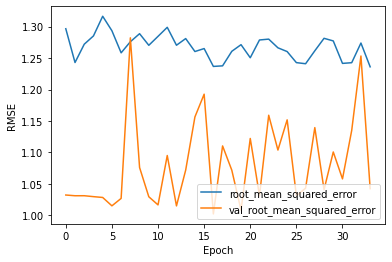

In [5]:
# word length and frequency CNN

# To feed the model, use the first WORDS_PER_EXCERPT words of the excerpt.
# If less is available, fill with empty
def extract_len_freq (word_list, no_words=WORDS_PER_EXCERPT):
    # cut to the right length, normalize, extract word frequency
    res = [[len(x) * 1.0 / max_word_length, word_freq(x)] for x in word_list[:no_words]]
    if len(res) < no_words:
        res += [[0,0],] * (no_words - len(res))
    res = np.array(res, dtype=np.float)
    return res

def nn_preprocess_len_freq (data):
    return np.vstack(data.word_list.apply(extract_len_freq).to_numpy()).reshape((-1,WORDS_PER_EXCERPT,2))

def build_cnn_len_freq (hp, augmented=use_augmentation):
    nn = models.Sequential()
    nn.add(layers.Input(shape=(WORDS_PER_EXCERPT,2)))
    num_conv_blocks = hp.Int('conv_blocks', 1,5)
    for i in range(num_conv_blocks):
        with hp.conditional_scope('conv_blocks', list(range(i+1,5+1))): # num > i
            nn.add(layers.Conv1D(hp.Int('filters_conv%i' % i,2,16,step=2),
                (min(nn.output_shape[1], hp.Int('kernel_conv%i' % i,2,16,step=2)),), 
                activation='relu'))
            pooling_choice = hp.Choice('pooling%i' % i, ['avg', 'max', 'none'])
            with hp.conditional_scope('pooling%i' % i, ['avg', 'max']):
                if pooling_choice == 'max':
                    nn.add(layers.MaxPooling1D(
                        (min(nn.output_shape[1], hp.Int('kernel_pool%i' % i,2,8,step=2)),)
                    ))
                elif pooling_choice == 'avg':
                    nn.add(layers.AveragePooling1D(
                        (min(nn.output_shape[1], hp.Int('kernel_pool%i' % i,2,8,step=2)),)
                    ))
            nn.add(layers.Dropout(hp.Float('dropout',0.,0.7,step=0.1)))
    nn.add(layers.Flatten())
    num_dense_blocks = hp.Int('dense_blocks', 1,3)
    for i in range(num_dense_blocks):
        with hp.conditional_scope('dense_blocks', list(range(i+1,3+1))): # num > i
            nn.add(layers.Dropout(hp.Float('dropout',0.,0.7,step=0.1)))
            if hp.Choice('batch_norm', [True, False]):
                nn.add(layers.BatchNormalization())
            nn.add(layers.Dense(hp.Int('dense%i' % i,4,64,step=4), activation='relu'))
    if hp.Choice('batch_norm_output', [True, False]):
        nn.add(layers.BatchNormalization())
    nn.add(layers.Dense(1))
    
    if augmented:
        loss = (lambda y1,y2,w=None : augmented_loss(tf.keras.losses.MeanSquaredError(), y1,y2,w))
    else:
        loss = tf.keras.losses.MeanSquaredError()

    nn.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4,0.3, sampling='log')),
               loss=loss,
               metrics=['RootMeanSquaredError'])
    
    return nn

if use_augmentation:
    best_hyperparameters_len_freq_dict = {
        'conv_blocks': 2, 'filters_conv0': 10, 
        'kernel_conv0': 14, 'pooling0': 'max', 
        'kernel_pool0': 4, 'dropout': 0.2, 'dense_blocks': 3,
        'batch_norm': 1, 'dense0': 64, 'batch_norm_output': 1, 
        'learning_rate': 0.0009090024729461547, 
        'filters_conv1': 2, 'kernel_conv1': 14, 
        'pooling1': 'avg', 'kernel_pool1': 8, 'dense1': 32, 
        'dense2': 60, 'tuner/epochs': 32, 
        'tuner/initial_epoch': 0, 'tuner/bracket': 0, 
        'tuner/round': 0
    }
else:
    best_hyperparameters_len_freq_dict = {
        'conv_blocks': 2, 'filters_conv0': 8, 
        'kernel_conv0': 10, 'pooling0': 'none', 
        'dropout': 0.2, 'dense_blocks': 2, 'batch_norm': 1, 
        'dense0': 12, 'batch_norm_output': 0, 
        'learning_rate': 0.018757792810801824, 
        'filters_conv1': 12, 'kernel_conv1': 6, 
        'pooling1': 'avg', 'kernel_pool1': 4, 'dense1': 4, 
        'tuner/epochs': 32, 'tuner/initial_epoch': 11, 
        'tuner/bracket': 1, 'tuner/round': 1, 
        'tuner/trial_id': '0011a1157813e370e78f8a237ca72049'
    }

# fit the model
X_train, X_test, y_train, y_test, pca = split_data (data_train_val, target='target', indices=indices, pca=False)
nn_inputs_len_freq = nn_preprocess_len_freq(data_train_val)
best_model_len_freq = fit_from_hp_dict(
    build_cnn_len_freq, best_hyperparameters_len_freq_dict, 
    nn_inputs_len_freq, indices, y_train, y_test
)
data_train_val['cnn_word_len+freq'] = best_model_len_freq.predict(nn_inputs_len_freq)
del X_train, X_test, y_train, y_test, pca, nn_inputs_len_freq

# apply it to the test data
nn_inputs_len_freq = nn_preprocess_len_freq(data_test)
data_test['cnn_word_len+freq'] = best_model_len_freq.predict(nn_inputs_len_freq)
del nn_inputs_len_freq

Epoch 1/1024
71/71 [==============================] - 2s 17ms/step - loss: 1.8261 - root_mean_squared_error: 1.4577 - val_loss: 1.4089 - val_root_mean_squared_error: 1.0961
Epoch 2/1024
71/71 [==============================] - 1s 10ms/step - loss: 1.4036 - root_mean_squared_error: 1.3112 - val_loss: 1.2795 - val_root_mean_squared_error: 1.4935
Epoch 3/1024
71/71 [==============================] - 1s 10ms/step - loss: 1.2407 - root_mean_squared_error: 1.2845 - val_loss: 0.9853 - val_root_mean_squared_error: 1.3427
Epoch 4/1024
71/71 [==============================] - 1s 10ms/step - loss: 1.0006 - root_mean_squared_error: 1.2643 - val_loss: 1.0575 - val_root_mean_squared_error: 1.4063
Epoch 5/1024
71/71 [==============================] - 1s 11ms/step - loss: 1.0160 - root_mean_squared_error: 1.3387 - val_loss: 0.8598 - val_root_mean_squared_error: 1.2598
Epoch 6/1024
71/71 [==============================] - 1s 13ms/step - loss: 1.1055 - root_mean_squared_error: 1.2642 - val_loss: 1.7184 

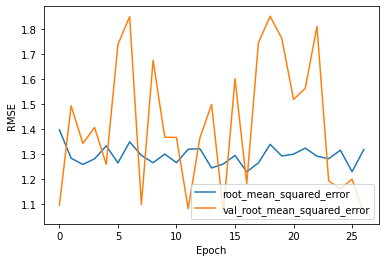

In [6]:
# embedding cnn

# For now, let's use the first WORDS_PER_EXCERPT words again. We will expand it to include the entire excerpts later..

def extract_emb (emb_matrix, no_words=WORDS_PER_EXCERPT):
    # cut or pad to the right length
    return np.concatenate([emb_matrix[:no_words,:], np.zeros([max(0,no_words-emb_matrix.shape[0]),emb_matrix.shape[1]])])

def nn_preprocess_emb (data):
    return np.vstack(data.word_embeddings.apply(extract_emb).to_numpy()).reshape((-1,WORDS_PER_EXCERPT,embedding_dim))

def build_cnn_emb (hp, augmented=use_augmentation):
    nn = models.Sequential()
    nn.add(layers.Input(shape=(WORDS_PER_EXCERPT,embedding_dim)))
    num_conv_blocks = hp.Int('conv_blocks', 0,5)
    for i in range(num_conv_blocks):
        with hp.conditional_scope('conv_blocks', list(range(i+1,5+1))): # num > i
            nn.add(layers.Conv1D(hp.Int('filters_conv%i' % i,2,16,step=2),
                (min(nn.output_shape[1], hp.Int('kernel_conv%i' % i,2,16,step=2)),), 
                activation='relu'))
            pooling_choice = hp.Choice('pooling%i' % i, ['avg', 'max', 'none'])
            with hp.conditional_scope('pooling%i' % i, ['avg', 'max']):
                if pooling_choice == 'max':
                    nn.add(layers.MaxPooling1D(
                        (min(nn.output_shape[1], hp.Int('kernel_pool%i' % i,2,8,step=2)),)
                    ))
                elif pooling_choice == 'avg':
                    nn.add(layers.AveragePooling1D(
                        (min(nn.output_shape[1], hp.Int('kernel_pool%i' % i,2,8,step=2)),)
                    ))
            nn.add(layers.Dropout(hp.Float('dropout',0.,0.7,step=0.1)))
    nn.add(layers.Flatten())
    num_dense_blocks = hp.Int('dense_blocks', 1,5)
    for i in range(num_dense_blocks):
        with hp.conditional_scope('dense_blocks', list(range(i+1,5+1))): # num > i
            nn.add(layers.Dropout(hp.Float('dropout',0.,0.7,step=0.1)))
            if hp.Choice('batch_norm', [True, False]):
                nn.add(layers.BatchNormalization())
            nn.add(layers.Dense(hp.Int('dense%i' % i,4,64,step=4), activation='relu'))
    if hp.Choice('batch_norm_output', [True, False]):
        nn.add(layers.BatchNormalization())
    nn.add(layers.Dense(1))
    
    if augmented:
        loss = (lambda y1,y2,w=None : augmented_loss(tf.keras.losses.MeanSquaredError(), y1,y2,w))
    else:
        loss = tf.keras.losses.MeanSquaredError()

    nn.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4,0.3, sampling='log')),
               loss=loss,
               metrics=['RootMeanSquaredError'])
    
    return nn

if use_augmentation:
    best_hyperparameters_emb_dict = {
        'conv_blocks': 3, 'dense_blocks': 2, 
        'dropout': 0.30000000000000004, 'batch_norm': 0, 
        'dense0': 16, 'batch_norm_output': 1, 
        'learning_rate': 0.08197541995276879, 
        'filters_conv0': 2, 'kernel_conv0': 14, 
        'pooling0': 'max', 'kernel_pool0': 4, 
        'filters_conv1': 6, 'kernel_conv1': 12, 
        'pooling1': 'none', 'dense1': 44, 'filters_conv2': 14, 
        'kernel_conv2': 4, 'pooling2': 'avg', 
        'kernel_pool2': 2, 'tuner/epochs': 43, 
        'tuner/initial_epoch': 15, 'tuner/bracket': 2, 
        'tuner/round': 1, 
        'tuner/trial_id': 'dbed8e7c1c9d30298fe0430de255d50f'}
else:
    best_hyperparameters_emb_dict = {
        'conv_blocks': 1, 'dense_blocks': 2, 
        'dropout': 0.30000000000000004, 'batch_norm': 0, 
        'dense0': 48, 'batch_norm_output': 1, 
        'learning_rate': 0.002693667798794543, 
        'dense1': 12, 'filters_conv0': 10, 'kernel_conv0': 4, 
        'pooling0': 'max', 'kernel_pool0': 6, 
        'tuner/epochs': 43, 'tuner/initial_epoch': 15, 
        'tuner/bracket': 4, 'tuner/round': 3, 
        'tuner/trial_id': '6ef193d541fe31f3ba90e45aedbaafdf'
    }

# fit the model
X_train, X_test, y_train, y_test, pca = split_data (data_train_val, target='target', indices=indices, pca=False)
nn_inputs_emb = nn_preprocess_emb(data_train_val)
best_model_emb = fit_from_hp_dict(
    build_cnn_emb, best_hyperparameters_emb_dict, 
    nn_inputs_emb, indices, y_train, y_test
)
data_train_val['cnn_word_embeddings'] = best_model_emb.predict(nn_inputs_emb)
del X_train, X_test, y_train, y_test, pca, nn_inputs_emb

# apply it to the test data
nn_inputs_emb = nn_preprocess_emb(data_test)
data_test['cnn_word_embeddings'] = best_model_emb.predict(nn_inputs_emb)
del nn_inputs_emb

Epoch 1/1024
71/71 [==============================] - 4s 24ms/step - loss: 1.7469 - root_mean_squared_error: 1.3422 - val_loss: 1.7250 - val_root_mean_squared_error: 1.0466
Epoch 2/1024
71/71 [==============================] - 1s 16ms/step - loss: 1.3803 - root_mean_squared_error: 1.3856 - val_loss: 1.5030 - val_root_mean_squared_error: 1.0339
Epoch 3/1024
71/71 [==============================] - 1s 16ms/step - loss: 1.2633 - root_mean_squared_error: 1.2999 - val_loss: 1.4952 - val_root_mean_squared_error: 1.0065
Epoch 4/1024
71/71 [==============================] - 1s 16ms/step - loss: 1.0381 - root_mean_squared_error: 1.2210 - val_loss: 1.1702 - val_root_mean_squared_error: 0.9991
Epoch 5/1024
71/71 [==============================] - 1s 16ms/step - loss: 0.7817 - root_mean_squared_error: 1.2246 - val_loss: 1.7585 - val_root_mean_squared_error: 0.9796
Epoch 6/1024
71/71 [==============================] - 1s 16ms/step - loss: 0.7644 - root_mean_squared_error: 1.1935 - val_loss: 1.0721 

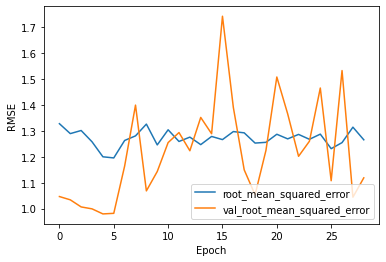

In [7]:
# embedding lstm

def extract_emb (emb_matrix, no_words=WORDS_PER_EXCERPT):
    # cut or pad to the right length
    return np.concatenate([emb_matrix[:no_words,:], np.zeros([max(0,no_words-emb_matrix.shape[0]),emb_matrix.shape[1]])])

def nn_preprocess_emb (data):
    return np.vstack(data.word_embeddings.apply(extract_emb).to_numpy()).reshape((-1,WORDS_PER_EXCERPT,embedding_dim))

def build_lstm_emb (hp, augmented=use_augmentation):
    nn = models.Sequential()
    nn.add(layers.Input(shape=(WORDS_PER_EXCERPT,embedding_dim)))
    num_conv_blocks = hp.Int('lstm_blocks', 1,1)
    for i in range(num_conv_blocks):
        with hp.conditional_scope('lstm_blocks', list(range(i+1,5+1))): # num > i
            nn.add(layers.LSTM(
                hp.Int('lstm_units%i' % i, 8,128, sampling='log')
            ))
            nn.add(layers.Dropout(hp.Float('dropout',0.,0.7,step=0.1)))
    nn.add(layers.Flatten())
    num_dense_blocks = hp.Int('dense_blocks', 1,5)
    for i in range(num_dense_blocks):
        with hp.conditional_scope('dense_blocks', list(range(i+1,5+1))): # num > i
            nn.add(layers.Dropout(hp.Float('dropout',0.,0.7,step=0.1)))
            if hp.Choice('batch_norm', [True, False]):
                nn.add(layers.BatchNormalization())
            nn.add(layers.Dense(hp.Int('dense%i' % i,4,64,step=4), activation='relu'))
    if hp.Choice('batch_norm_output', [True, False]):
        nn.add(layers.BatchNormalization())
    nn.add(layers.Dense(1))
    
    if augmented:
        loss = (lambda y1,y2,w=None : augmented_loss(tf.keras.losses.MeanSquaredError(), y1,y2,w))
    else:
        loss = tf.keras.losses.MeanSquaredError()

    nn.compile(optimizer=tf.keras.optimizers.Adam(
                hp.Float('learning_rate', 1e-4,0.3, sampling='log')
               ),
               loss=loss,
               metrics=['RootMeanSquaredError'])
    
    return nn

if use_augmentation:
    best_hyperparameters_emb_lstm_dict = {
        'lstm_blocks': 1, 'lstm_units0': 55, 
        'dropout': 0.1, 'dense_blocks': 1, 
        'batch_norm': 1, 'dense0': 36, 
        'batch_norm_output': 0, 
        'learning_rate': 0.0036906795279518277, 
        'tuner/epochs': 128, 'tuner/initial_epoch': 0, 
        'tuner/bracket': 0, 'tuner/round': 0
    }
else:
    best_hyperparameters_emb_lstm_dict = {
        'lstm_blocks': 1, 'lstm_units0': 66, 'dropout': 0.2, 
        'dense_blocks': 3, 'batch_norm': 1, 'dense0': 20, 
        'batch_norm_output': 1, 
        'learning_rate': 0.0022843219066342054, 'dense1': 60, 
        'dense2': 56, 'tuner/epochs': 43, 
        'tuner/initial_epoch': 0, 'tuner/bracket': 1, 
        'tuner/round': 0
    }

# fit the model
X_train, X_test, y_train, y_test, pca = split_data (data_train_val, target='target', indices=indices, pca=False)
nn_inputs_emb = nn_preprocess_emb(data_train_val)
best_model_emb_lstm = fit_from_hp_dict(
    build_lstm_emb, best_hyperparameters_emb_lstm_dict, 
    nn_inputs_emb, indices, y_train, y_test
)
data_train_val['lstm_word_embeddings'] = best_model_emb_lstm.predict(nn_inputs_emb)
del X_train, X_test, y_train, y_test, pca, nn_inputs_emb

# apply it to the test data
nn_inputs_emb = nn_preprocess_emb(data_test)
data_test['lstm_word_embeddings'] = best_model_emb_lstm.predict(nn_inputs_emb)
del nn_inputs_emb

In [8]:
# the final regressor
scalers = {
    'QuantileTransf': QuantileTransformer(),
    'Robust': RobustScaler()
}
if use_augmentation:
    sgdr_best_hps = {
        'loss': 'epsilon_insensitive', 
        'penalty': 'elasticnet', 'l1_ratio': 0.0, 
        'alpha': 0.1, 'epsilon': 0.001, 
        'learning_rate': 'invscaling', 
        'eta0': 0.01, 'power_t': 0.25
    }
    svm_best_hps = {
        'kernel': 'poly', 'degree': 3, 'gamma': 'auto', 
        'C': 10, 'epsilon': 0.1, 'shrinking': True}
    svm_best_scaler = 'QuantileTransf'
else:
    sgdr_best_hps = {
        'loss': 'squared_epsilon_insensitive', 'penalty': 'elasticnet', 
        'l1_ratio': 0.0, 'alpha': 0.1, 'epsilon': 0.001, 
        'learning_rate': 'invscaling', 'eta0': 0.01, 'power_t': 0.25
    }
    svm_best_hps = {
        'kernel': 'rbf', 'degree': 1, 'gamma': 'scale', 
        'C': 0.1, 'epsilon': 0.1, 'shrinking': True}
    svm_best_scaler = 'Robust'
sgdr_best_pca = False
sgdr_best_scaler = 'QuantileTransf'
svm_best_pca = False

# first let's see how it does
def try_SGDR_opt (data, indices=None, output=False):
    X_train, X_test, y_train, y_test, pca = split_data(data, pca=sgdr_best_pca, indices=indices, augmented=False)
    reg = make_pipeline(scalers[sgdr_best_scaler],
        SGDRegressor(
            **sgdr_best_hps,
            random_state=random_state
        ))
    reg.fit(X_train, y_train)
    print("SGDR RMSE: ", mean_squared_error(y_test, reg.predict(X_test), squared=False))
    if output:
        return reg
def try_SVM_opt (data, indices=None, output=False):
    X_train, X_test, y_train, y_test, pca = split_data(data, pca=svm_best_pca, indices=indices, augmented=False)
    reg = make_pipeline(scalers[svm_best_scaler],
                        SVR(
                            **svm_best_hps
                        ))
    reg.fit(X_train, y_train)
    print("SVM RMSE: ", mean_squared_error(y_test, reg.predict(X_test), squared=False))
    if output:
        return reg

print("rmse from validation:")
try_SGDR_opt(data_train_val, indices=indices)
try_SVM_opt(data_train_val, indices=indices)

# now retrain on full training data
X = data_train_val[data_train_val.columns.difference(noTrain_columns)]
y = data_train_val['target']
if use_augmentation:
    reg = make_pipeline(scalers[svm_best_scaler],
        SVR(
            **svm_best_hps
        ))
else:
    reg = make_pipeline(scalers[sgdr_best_scaler],
        SGDRegressor(
            **sgdr_best_hps,
            random_state=random_state
        ))
reg.fit(X,y)
print("rmse from full data:")
print("RMSE: ", mean_squared_error(y, reg.predict(X), squared=False))
del X, y

# finally, generate predictions for the test dataset
X = data_test[data_test.columns.difference(noTrain_columns)]
data_test['target'] = reg.predict(X)

rmse from validation:
SGDR RMSE:  0.6335546928826459
SVM RMSE:  0.6159879207223449
rmse from full data:
RMSE:  0.47869556187029527


In [9]:
# save the submission
data_test[['id','target']].to_csv('submission.csv', index=False)